## CP#21 - Medical X-Ray Image Classifier: Pneumonia Detection

### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import cv2
from sklearn.metrics import precision_score, recall_score
import os

### Function definitions

In [2]:
# Function prints information on number of files in folder structure
def count_files_in_subdirs(root_dir):
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(root_dir, split)
        print(f'\n{split.upper()} SET:')
        
        if os.path.exists(split_path):
            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                    print(f'  {class_name}: {num_files} plików')
        else:
            print(f'  Folder {split} does not exists.')

### Script parameters and constant values

In [3]:
local_dir_dataset ="../../data" 
local_dir_train = "../../data/train"
local_dir_test = "../../data/test"
local_dir_val = "../../data/val"
device = torch.device("cpu")
xysize = 64


### Preprocessing the Dataset

In [4]:
# Statistical analysis of files in dataset after balancing TRAIN - NORMAL SET 
count_files_in_subdirs(local_dir_dataset)


TRAIN SET:
  NORMAL: 4024 plików
  PNEUMONIA: 3876 plików

VAL SET:
  NORMAL: 9 plików
  PNEUMONIA: 9 plików

TEST SET:
  NORMAL: 234 plików
  PNEUMONIA: 390 plików


In [5]:
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # grayscale
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),    
    transforms.Resize((xysize, xysize)), #output size
    transforms.RandomApply(  # random blur, probability = 0.3
        [transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 5.0))],
        p=0.3  # 30% of train set will be blured
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # general normalization for grayscale
])

In [6]:
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((xysize, xysize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [7]:
dataset_train = datasets.ImageFolder(root=local_dir_train, transform=transform_train)
dataset_test = datasets.ImageFolder(root=local_dir_test, transform=transform_test)
dataset_val = datasets.ImageFolder(root=local_dir_val, transform=transform_test)

In [8]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

### Data Visualization

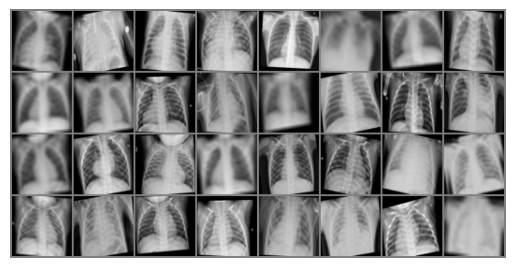

In [9]:
# Function to visualize a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.axis('off')
imshow(out, title="")

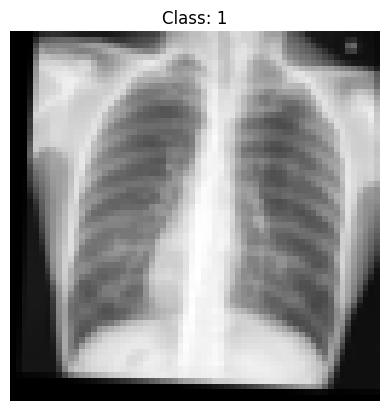

In [10]:
image = inputs[4]  # Torch.Size([1, 128, 128])

# denormalization
mean = 0.5
std = 0.5
image = image * std + mean 

# 
image = image.squeeze()

# visualzaton in grayscale
plt.imshow(image, cmap='gray')
plt.title(f'Class: {classes[0]}')
plt.axis('off')
plt.show()

### 3-layer Convolutional Nerual Network architecure

In [11]:
class BasicCNNV2(nn.Module):
    def __init__(self):
        super(BasicCNNV2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # Head of the CNN
        self.fc1 = nn.Linear(128 * (xysize // 8) * (xysize // 8), out_features=512)
        self.fc2 = nn.Linear(512, 1) # 1 - binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))  # Aktywacja sigmoid na wyjściu
        return x 

In [12]:
model = BasicCNNV2()
model.to(device)

criterion = criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training the model
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        labels = labels.float().view(-1, 1)  # Konwersja etykiet na float i dopasowanie kształtu

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Obliczenie straty
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Obliczanie accuracy (dla klasyfikacji binarnej zamiast torch.max stosujemy round)
        predicted = outputs.round()  # Zaokrąglamy wartości do 0 lub 1
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total * 100
    
    # Walidacja
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:  # Poprawiona nazwa zmiennej
            val_inputs, val_labels = val_inputs.to(device, non_blocking=True), val_labels.to(device, non_blocking=True)
            val_labels = val_labels.float().view(-1, 1)  # Dopasowanie kształtu

            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_inputs.size(0)
            
            # Obliczanie accuracy (dla binarnej klasyfikacji)
            val_predicted = val_outputs.round()  # Zaokrąglamy wartości do 0 lub 1
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_correct / val_total * 100

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%')


Epoch 1/30, Loss: 0.2415, Accuracy: 88.85%, Validation Loss: 21.2636, Validation Accuracy: 79.65%
Epoch 2/30, Loss: 0.0979, Accuracy: 96.32%, Validation Loss: 25.0254, Validation Accuracy: 76.60%
Epoch 3/30, Loss: 0.0811, Accuracy: 97.11%, Validation Loss: 25.4010, Validation Accuracy: 80.29%
Epoch 4/30, Loss: 0.0680, Accuracy: 97.46%, Validation Loss: 28.7586, Validation Accuracy: 79.33%
Epoch 5/30, Loss: 0.0655, Accuracy: 97.59%, Validation Loss: 13.0033, Validation Accuracy: 87.18%
Epoch 6/30, Loss: 0.0615, Accuracy: 97.70%, Validation Loss: 33.3408, Validation Accuracy: 75.64%
Epoch 7/30, Loss: 0.0565, Accuracy: 97.96%, Validation Loss: 26.8304, Validation Accuracy: 78.85%
Epoch 8/30, Loss: 0.0543, Accuracy: 98.04%, Validation Loss: 31.1416, Validation Accuracy: 79.81%
Epoch 9/30, Loss: 0.0495, Accuracy: 98.18%, Validation Loss: 36.0831, Validation Accuracy: 79.65%
Epoch 10/30, Loss: 0.0470, Accuracy: 98.43%, Validation Loss: 32.5005, Validation Accuracy: 76.28%
Epoch 11/30, Loss: 

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch.nn.functional as F

model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
all_probs = []  # Do AUC

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).squeeze(1)  # Usunięcie wymiaru (batch_size, 1) → (batch_size)
        probs = torch.sigmoid(outputs)  # Konwersja logitów na prawdopodobieństwa
        predicted = probs.round()  # 0.5 jako próg dla klasy 1

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Zapisanie prawdopodobieństw

# Obliczanie metryk
accuracy = correct / total
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
auc = roc_auc_score(all_labels, all_probs)  # Tylko dla klasy binarnej

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'AUC: {auc:.4f}')


Validation Accuracy: 62.50%
Precision: 0.6250
Recall: 1.0000
F1-score: 0.7692
AUC: 0.9366
